# **Problem 2** 
The baseline model we did in lectures is called ResNet-11. Build a new version of ResNet (ResNet-18). Train it on CIFAR-10. Plot the training loss, validation loss, and validation accuracy. Compare the classification accuracy, and model size across the two versions of ResNet (11, 18). How does the complexity grow as you increase the network depth?

In [6]:
# Main Libraries
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np

# Utility Libraries (QoL functions)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

# Visualization and Evaluation Libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean,std)])

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=normalize)
validation_dataset = datasets.CIFAR10(root='./data', train=False, transform=normalize)

training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified


In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels) 


        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))

        out += self.shortcut(x)

        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        

        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(training_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.update(1)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        training_accuracy = 100 * correct / total
        training_accuracies.append(training_accuracy)
    
        model.eval()
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                
        validation_loss = running_loss / len(validation_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)

        pbar.set_postfix({'Training Loss ': training_loss, 'Validation Loss ': validation_loss})

torch.save(model, 'ResNet18')

Epoch 20/20: 100%|██████████| 1563/1563 [00:29<00:00, 53.41 batch/s, Training Loss =0.0315, Validation Loss =0.0219]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

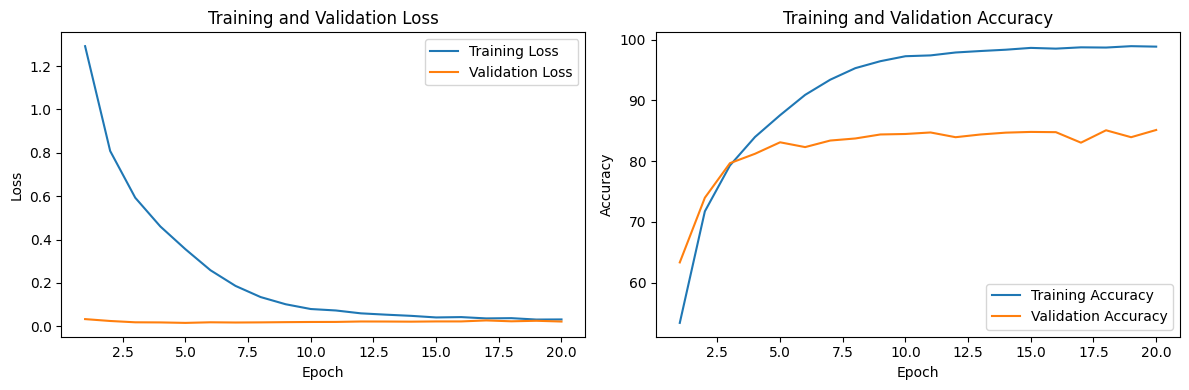

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.94      0.91      0.93      1000
           2       0.81      0.79      0.80      1000
           3       0.72      0.71      0.71      1000
           4       0.83      0.84      0.83      1000
           5       0.81      0.76      0.79      1000
           6       0.90      0.89      0.89      1000
           7       0.87      0.90      0.89      1000
           8       0.89      0.92      0.90      1000
           9       0.88      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



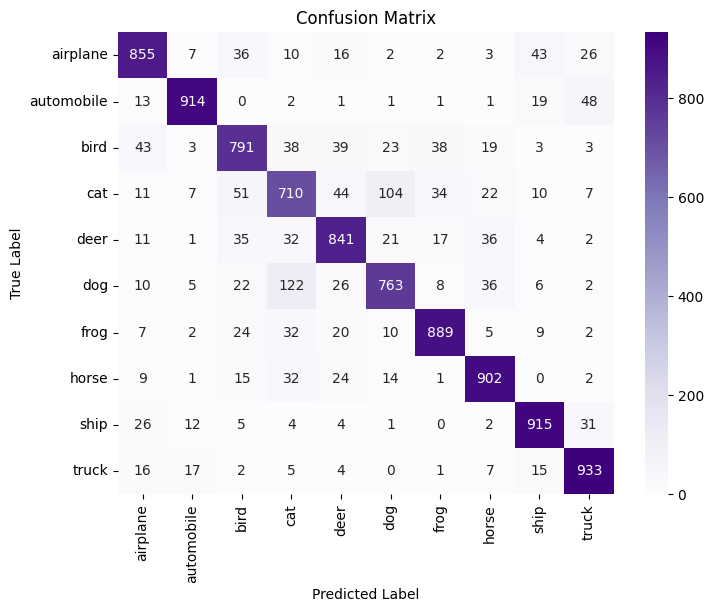

In [8]:
summary(model, (3, 32, 32))  # Input images are of shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, epochs + 1)

# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()